In [1]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import load_data
from Project_Models import RNN_Model, LSTM_Model
import torch
import torch.nn as nn

print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

def normalize(x):
    """ normalize data of each column """
    maxtensor = x.max(0, keepdim=True)[0]
    maxtensor[maxtensor==0] = 1e-4
    x_normed = x / maxtensor
    return x_normed, maxtensor

def standardize(x):
    mean = x.mean(0, keepdim=True)[0]
    mean[mean==0] = 1e-4
    std  = x.std(0, keepdim=True)[0]
    std[std==0] = 1e-4
    x_normed = (x - mean) / std
    return x_normed, mean, std

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = load_data.load_county_level('./data/covid19-severity-prediction/data')

updating to the latest version
update successful
current working dir: d:\dataset\CS184A-Covid19_severity_prediction
current device: GeForce RTX 3080
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [2]:
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()

def to_torch(x, device='cpu'):
    return torch.tensor(x).unsqueeze(-1).to(device).float()

FEATURES = [
    '#Hospitals', 
    '#ICU_beds', 
    'MedicareEnrollment,AgedTot2017', 
    'DiabetesPercentage', 
    'HeartDiseaseMortality',
    'StrokeMortality',
    'Smokers_Percentage',
    'RespMortalityRate2014',
    '#FTEHospitalTotal2017',
    "TotalM.D.'s,TotNon-FedandFed2017",
    '#HospParticipatinginNetwork2017']

In [4]:
# Preprocess Data

maxload = 1600 #

x = form_input_tensor(df, FEATURES,
    maxload=maxload).to(device)
for i in range(x.shape[1] - 1, 0, -1):
    x[:,i,-2] -= x[:,i-1,-2]
    x[:,i,-1] -= x[:,i-1,-1]

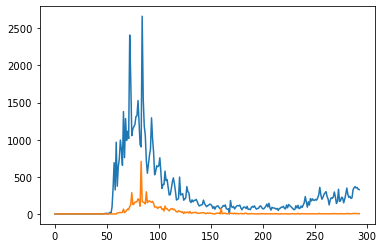

In [5]:
k=x[0][:,-2:]
kcase=k[:,0]
kd = k[:,1]
plt.plot(range(294), to_numpy(kcase))
plt.plot(range(294), to_numpy(kd))
plt.show()

In [5]:
x, xmean, xstd = standardize(x)
# x[torch.isnan(x)] = 0
print(f"#x nan: {(torch.sum(torch.isnan(x)))}")
# print("x:", x)

# y = form_labels_tensor(df, maxload=maxload).to(device)

# for i in range(y.shape[1] - 1, 0, -1):
#     y[:,i,-2] -= y[:,i-1,-2]
#     y[:,i,-1] -= y[:,i-1,-1]

# y, ymean, ystd = standardize(y)
# print(f"#y nan: {torch.sum(torch.isnan(y))}")
# print("y:", y * ymaxtensor)

Xtrain = x[:-50]
# Ytrain = y[:-50]
Xtest  = x[90:]
# Ytest  = y[90:]

#x nan: 0


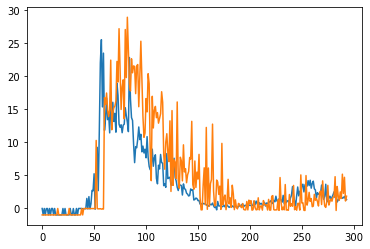

In [7]:
k=x[0][:,-2:]
kcase=k[:,0]
kd = k[:,1]
plt.plot(range(294), to_numpy(kcase))
plt.plot(range(294), to_numpy(kd))
plt.show()

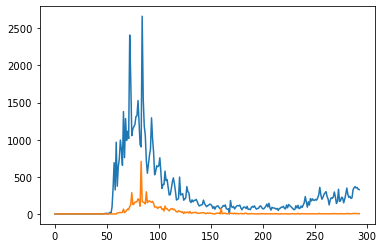

In [9]:
k=k*xstd[:,-2:]+xmean[:,-2:]
kcase=k[:,0]
kd = k[:,1]
plt.plot(range(294), to_numpy(kcase))
plt.plot(range(294), to_numpy(kd))
plt.show()

In [6]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.casefc1 = nn.Linear(hidden_size, 64)
        self.casefc2 = nn.Linear(64, 32)
        self.casefc4 = nn.Linear(32, 32)
        self.casefc5 = nn.Linear(32, 32)
        self.casefc3 = nn.Linear(32, 1)

        self.deathfc1 = nn.Linear(hidden_size, 64)
        self.deathfc2 = nn.Linear(64, 32)
        self.deathfc3 = nn.Linear(32, 1)
        self.residule = nn.Linear

        self.activation=nn.ReLU()
    
    def forward(self, out):
        # res block 1
        r1 = self.casefc1(out)
        case = self.activation(r1) + r1
        # res block 2
        r2 = self.casefc2(case)
        case = self.activation(r2) + r2
        # res block 3
        # r3 = self.casefc4(case)
        # case = self.activation(r3) + r3
        # res block 4
        r4 = self.casefc5(case)
        case = self.activation(r4)
        # output
        case = self.casefc3(case)

        # res block 1
        d1 = self.deathfc1(out)
        d = self.activation(d1) + d1
        # res block 2
        d2 = self.deathfc2(d)
        d = self.activation(d2)
        # output
        d = self.deathfc3(d)
        return torch.hstack((case, d))

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = Decoder(hidden_size)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        return self.decoder(out)

class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = Decoder(hidden_size)

    def forward(self, x):
        h0 = torch.ones(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.ones(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.decoder(out)

In [7]:
def trainModel(model, lr, epochs):

    print("training data shape:", Xtrain.shape)

    # train model
    # model = Classifier(input_size=Xtrain.shape[2], hidden_size=128, num_layers=3).to(device)
    # with torch.no_grad():
    #     print("Before training:", model(Xtrain) * ymaxtensor)

    criterion = lambda y, yhat: torch.sqrt(nn.MSELoss()(y, yhat))
    # criterion = nn.SmoothL1Loss()
    learning_rate = lr
    num_epoches = epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)

    trange = tqdm.trange(num_epoches)
    for epoch in trange:
        for i in range(1, Xtrain.shape[1]):
            yhat = model(Xtrain[:,:i,:])
            loss = criterion(yhat, Xtrain[:,i,-2:])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step(loss.item())
            trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Loss: {loss.item():.4f}')
            trange.refresh()
        # yhat = model(Xtrain)
        # loss = criterion(yhat, Ytrain)
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        # trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Loss: {loss.item():.4f}')
        # trange.refresh()

    # with torch.no_grad():
    #     print("After training:", (model(Xtest) * ymaxtensor))
    #     print("y:", (Ytest * ymaxtensor))
    
    return model

def trainModelOnlyEnd(model, lr, epochs):

    print("training data shape:", Xtrain.shape, Ytrain.shape)

    # train model
    # model = Classifier(input_size=Xtrain.shape[2], hidden_size=128, num_layers=3).to(device)
    # with torch.no_grad():
    #     print("Before training:", model(Xtrain) * ymaxtensor)

    criterion = lambda y, yhat: torch.sqrt(nn.MSELoss()(y, yhat))
    # criterion = nn.SmoothL1Loss()
    learning_rate = lr
    num_epoches = epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)

    trange = tqdm.trange(num_epoches)
    for epoch in trange:
        # for i in range(1, Xtrain.shape[1]):
        #     yhat = model(Xtrain[:,:i,:])
        #     loss = criterion(yhat, Xtrain[:,i,-2:])
        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()
        #     # scheduler.step(loss.item())
        #     trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Loss: {loss.item():.4f}')
        #     trange.refresh()
        yhat = model(Xtrain)
        loss = criterion(yhat, Ytrain)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Loss: {loss.item():.4f}')
        trange.refresh()

    # with torch.no_grad():
    #     print("After training:", (model(Xtest) * ymaxtensor))
    #     print("y:", (Ytest * ymaxtensor))
    
    return model

#x nan: 0
mse 42272185695252.9


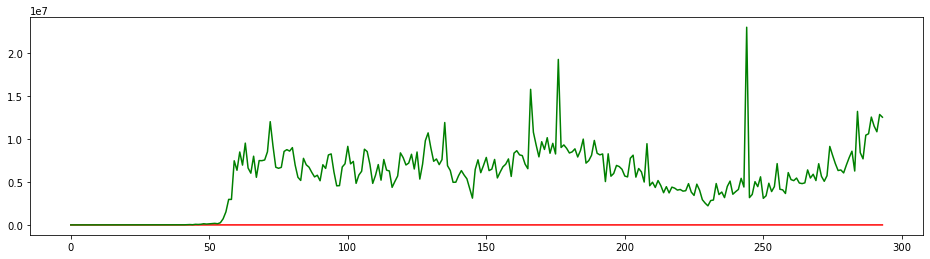

mse 63376140.190476194


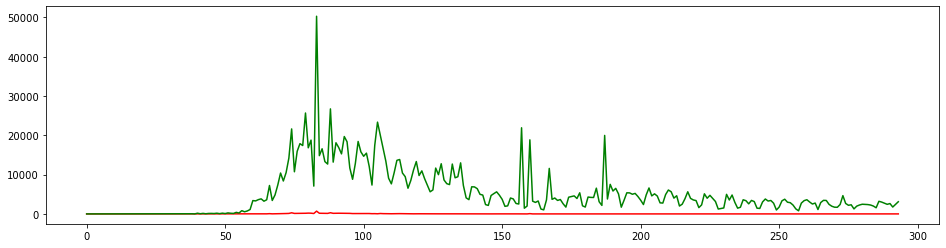

In [187]:
plotPrediction(rnn_onlyend, "Kings", "NY")

#x nan: 0
mse 11693.5


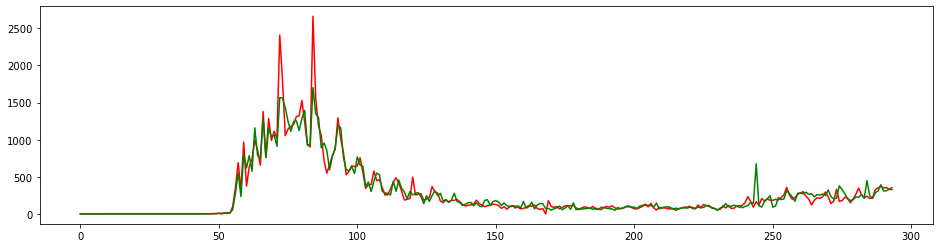

mse 269.78619260204084


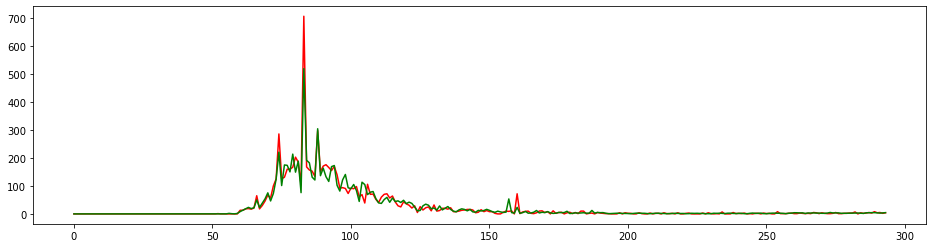

#x nan: 0
mse 24830.028911564626


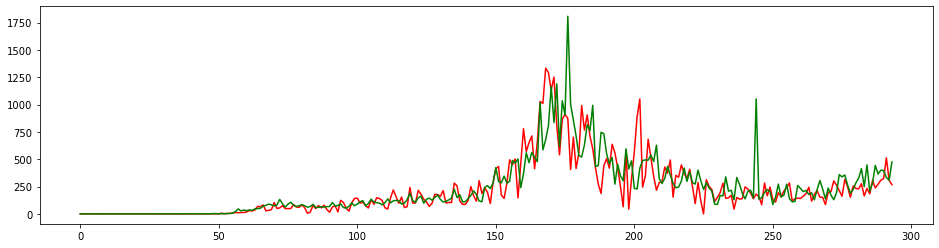

mse 42.96900244472789


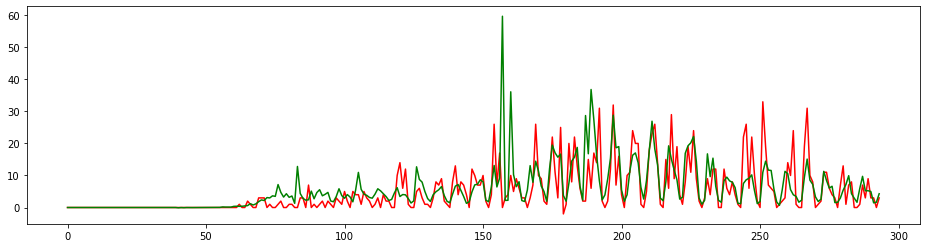

In [158]:
plotPrediction(rnn, "Kings", "NY")
plotPrediction(rnn, "Orange", "CA")

In [9]:
rnn=torch.load('./saved_models/rnn_predict_increase.model')

In [10]:
def evaluate(rangelist):
    msecases =[]
    msedeaths=[]
    for i in tqdm.tqdm(rangelist):
        county_name = df.iloc[i]['CountyName']
        state_name = df.iloc[i]['StateName']
        msecasei, msedeathi = plotPrediction(rnn, county_name, state_name, plot=False)
        msecases.append(msecasei)
        msedeaths.append(msedeathi)
    return [msecases, msedeaths]

In [198]:
testcasesmse, testdeathsmse = evaluate(range(1550, 1610))

100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


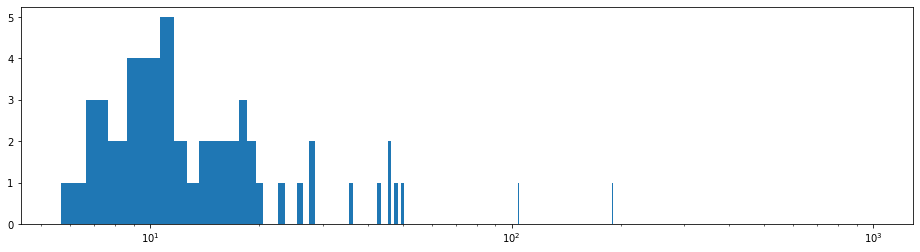

In [213]:
plt.figure(figsize=(16,4))
plt.gca().set_xscale('log')
plt.hist(testcasesmse, bins=1000)
plt.show()

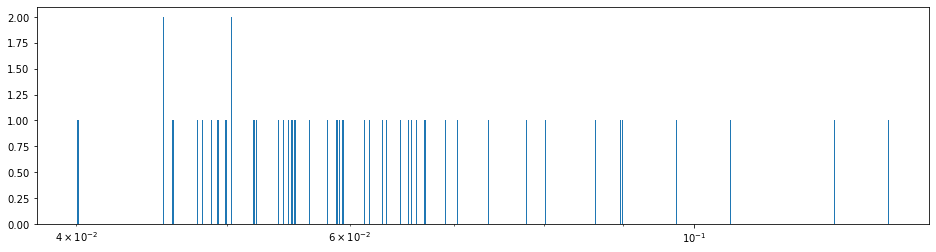

In [215]:
plt.figure(figsize=(16,4))
plt.gca().set_xscale('log')
plt.hist(testdeathsmse, bins=1000)
plt.show()

In [177]:
df.iloc[range(1560,1570)]

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,#Deaths_11-08-2020,#Deaths_11-09-2020,#Deaths_11-10-2020,#Deaths_11-11-2020,deaths,cases,tot_deaths,tot_cases,neighbor_deaths,neighbor_cases
809,19057,19.0,57.0,Des Moines,IA,Iowa,40.934101,-91.172928,40.833525,-91.141489,...,13,13,13,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,2129,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2370,46035,46.0,35.0,Davison,SD,South Dakota,43.672930,-98.128141,43.706368,-98.041463,...,12,12,12,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,1599,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2389,46073,46.0,73.0,Jerauld,SD,South Dakota,44.065429,-98.632315,44.087702,-98.562253,...,13,13,13,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,197,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2823,51023,51.0,23.0,Botetourt,VA,Virginia,37.552871,-79.810606,37.448222,-79.851418,...,13,13,13,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,553,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2422,47005,47.0,5.0,Benton,TN,Tennessee,36.075970,-88.073291,36.071513,-88.090020,...,11,11,12,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,568,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2430,47021,47.0,21.0,Cheatham,TN,Tennessee,36.262201,-87.092871,36.269635,-87.063974,...,12,12,12,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,1275,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
411,13065,13.0,65.0,Clinch,GA,Georgia,30.904785,-82.734136,31.017888,-82.740932,...,13,13,13,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,475,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
484,13213,13.0,213.0,Murray,GA,Georgia,34.780181,-84.763190,34.782329,-84.792066,...,11,11,11,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,1252,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2459,47079,47.0,79.0,Henry,TN,Tennessee,36.334804,-88.305258,36.319164,-88.293739,...,13,13,13,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,1078,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2472,47105,47.0,105.0,Loudon,TN,Tennessee,35.734730,-84.313158,35.759679,-84.286322,...,13,13,13,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,1910,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
plotPrediction(rnn, "Clinch", "GA")

#x nan: 0
mse 11.008118921396683


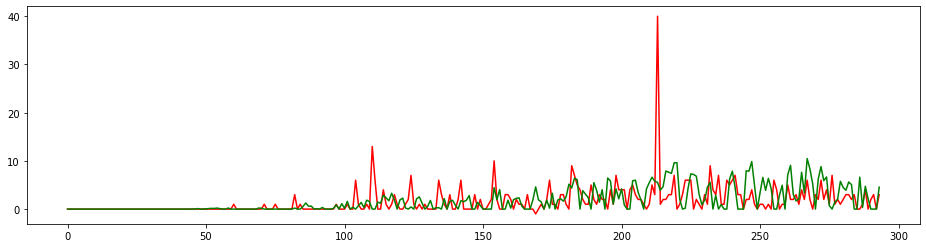

mse 0.08961944190823302


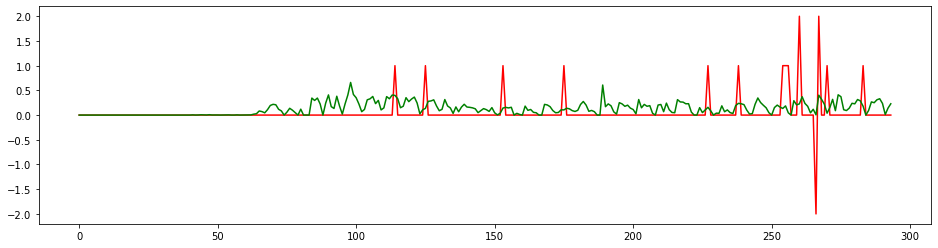

In [188]:
plotPrediction(rnn, "Clinch", "GA")

#x nan: 0
mse 10593.090136054421


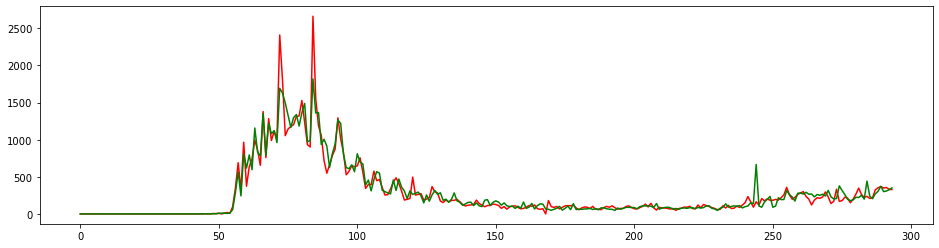

mse 268.4673150510204


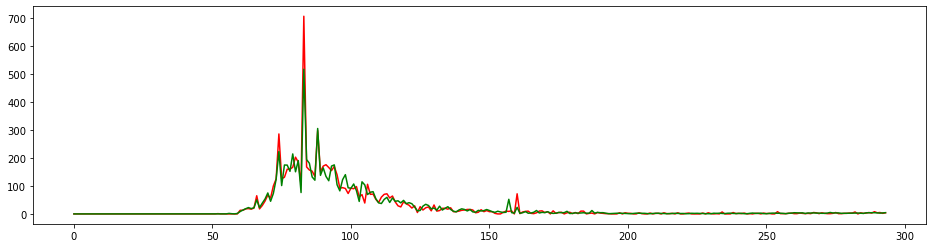

In [185]:
plotPrediction(rnn, "Kings", "NY")

#x nan: 0
mse 17.714202673256803


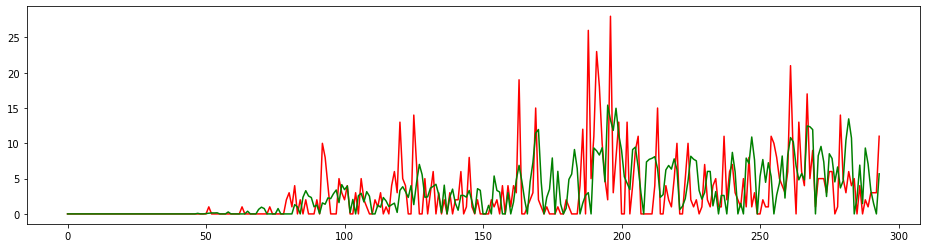

mse 0.05440661696349682


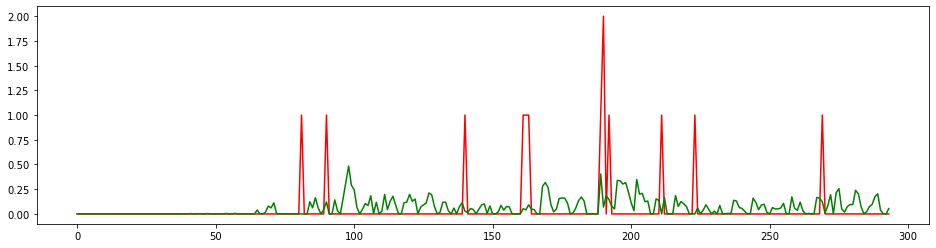

In [175]:
plotPrediction(rnn, "Prince Edward", "VA")

#x nan: 0
mse 18.278456499787413


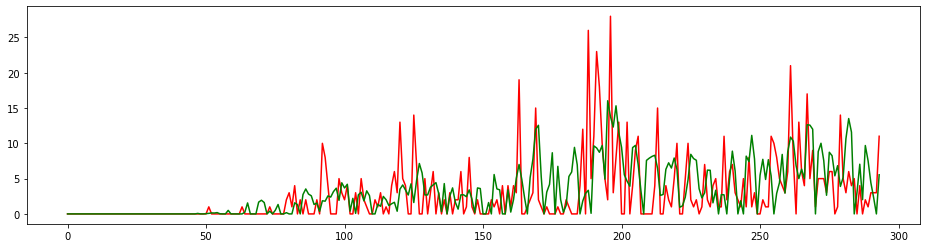

mse 0.05504489431575853


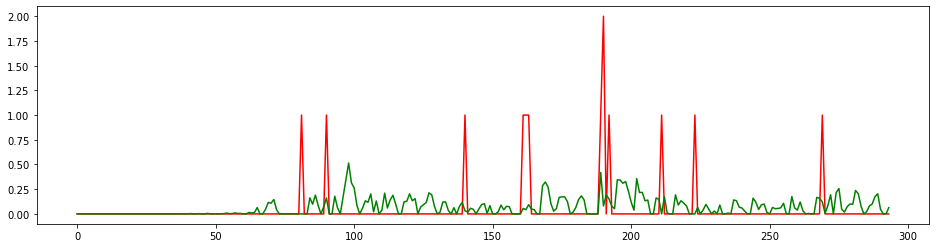

In [186]:
plotPrediction(rnn, "Prince Edward", "VA")

In [69]:
rnn = RNN(input_size=Xtrain.shape[2], hidden_size=128, num_layers=3).to(device)

In [182]:
trainModel(rnn, 1e-6, 100)

Epoch [100/100], Loss: 0.5761: 100%|██████████| 100/100 [16:00<00:00,  9.61s/it]


RNN(
  (rnn): RNN(13, 128, num_layers=3, batch_first=True)
  (casefc1): Linear(in_features=128, out_features=64, bias=True)
  (casefc2): Linear(in_features=64, out_features=32, bias=True)
  (casefc4): Linear(in_features=32, out_features=32, bias=True)
  (casefc5): Linear(in_features=32, out_features=32, bias=True)
  (casefc3): Linear(in_features=32, out_features=1, bias=True)
  (deathfc1): Linear(in_features=128, out_features=64, bias=True)
  (deathfc2): Linear(in_features=64, out_features=32, bias=True)
  (deathfc3): Linear(in_features=32, out_features=1, bias=True)
  (activation): ReLU()
)

In [13]:
lstm = LSTM(input_size=Xtrain.shape[2], hidden_size=128, num_layers=3).to(device)

In [14]:
Xtrain.shape, Xtest.shape

(torch.Size([1550, 294, 13]), torch.Size([1510, 294, 13]))

In [15]:
trainModel(lstm, 1e-4, 100)

Epoch [52/100], Loss: 0.5745:  51%|█████     | 51/100 [29:01<27:53, 34.15s/it]


RuntimeError: CUDA error: an illegal memory access was encountered

In [ ]:
trainModel(lstm, 1e-5, 30)
trainModel(lstm, 1e-6, 100)

In [ ]:
torch.save(lstm, "./saved_models/lstm_withdecoder_predict_increase.model")

In [221]:
plotPrediction(lstm, "Prince Edward", "VA")

RuntimeError: CUDA error: unspecified launch failure

In [195]:
def plotPrediction(model, countyname, statename, plot=True):
    orange = df[(df['StateName'] == statename) & (df['CountyName'] == countyname)]
    x = form_input_tensor(orange, FEATURES, maxload=maxload).to(device)
    truey = x[:, :, -2:]
    for i in range(x.shape[1] - 1, 0, -1):
        x[:,i,-2] -= x[:,i-1,-2]
        x[:,i,-1] -= x[:,i-1,-1]
    xnorm = (x - xmean) / xstd
    x[torch.isnan(x)]=0
    # check if there is nan in x
    # print(f"#x nan: {(torch.sum(torch.isnan(x)))}")

    # print(f"x.shape: {x.shape}")
    # print("x:", x * )
    # y = form_labels_tensor(df, maxload=maxload).to(device)
    # ynorm = (y - ymean) / ystd
    # print(f"#y nan: {torch.sum(torch.isnan(y))}")

    yhat = torch.zeros((x.shape[1], 2), dtype=torch.float32, device='cuda')
    for i in range(1, x.shape[1]):
        yhati = None
        with torch.no_grad():
            xi = xnorm[:,:i,:]
            # print(xi.shape)
            yhati = model(xi)
        # print(yhati.shape)
        # yhati = yhati
        # print(yhati.shape)
        yhat[i] = (yhati)
    # print(yhat)
    yhat = yhat*xstd[:,-2:]+xmean[:,-2:]
    yhat[yhat<0]=0

    truey = to_numpy(truey)
    yhat = to_numpy(yhat)
    if plot:
        plt.figure(figsize=(16,4))
        # plt.ylim((0, 70000))
        plt.plot(range(len(truey)),truey[:,0],'r-')
        plt.plot(range(len(truey)),yhat[:,0],'g-')
        # plt.plot(range(len(truey)), np.absolute(truey[:,0]-yhat[:,0]), 'b-')
        
        plt.show()
        plt.figure(figsize=(16,4))
        plt.plot(range(len(truey)),truey[:,1],'r-')
        plt.plot(range(len(truey)),yhat[:,1],'g-')
        # plt.plot(range(len(truey)), np.absolute(truey[:,1]-yhat[:,1]), 'b-')
        plt.show()
    msecases = (np.sum((truey[:,0] - yhat[:,0]) ** 2) / len(truey))
    msedeaths= (np.sum((truey[:,1] - yhat[:,1]) ** 2) / len(truey))
    return msecases, msedeaths

In [142]:
# torch.save(rnn, "./saved_models/rnn_predict_increase.model")

#x nan: 0
mse 24228.43537414966


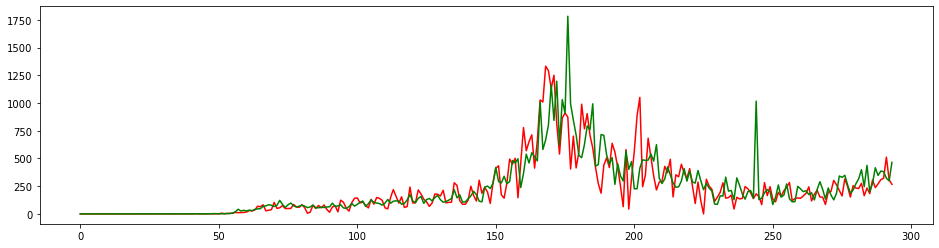

mse 42.43281316432823


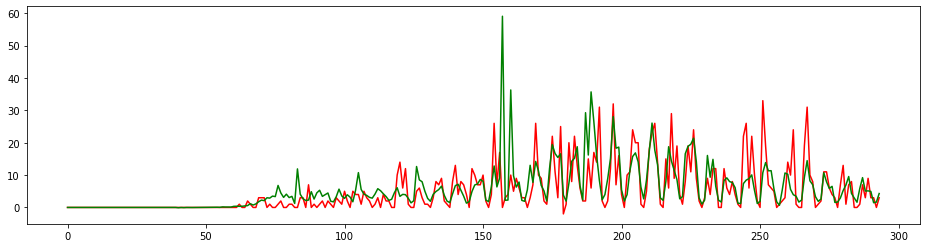

In [141]:
plotPrediction(rnn, 'Orange', 'CA')

#x nan: 0
mse 24205.469387755104


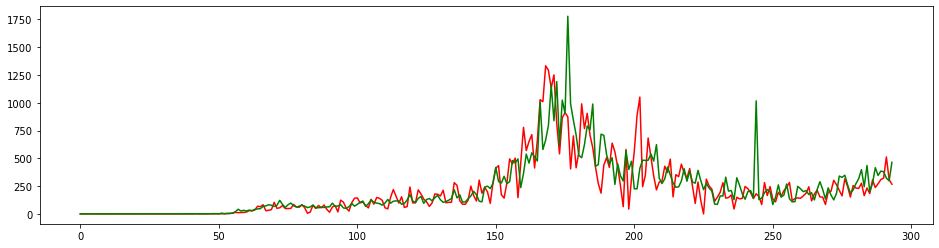

mse 42.63379902742347


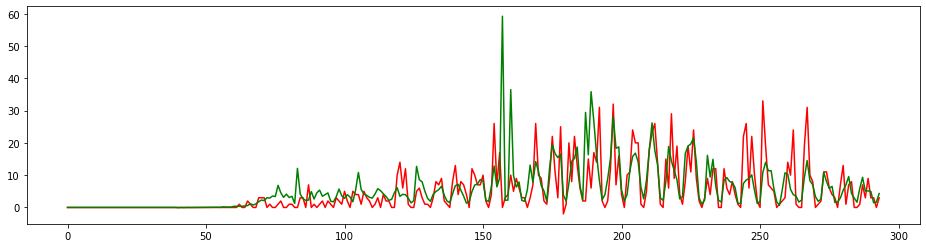

In [137]:
plotPrediction(rnn, 'Orange', 'CA')

#x nan: 0
mse 24205.469387755104


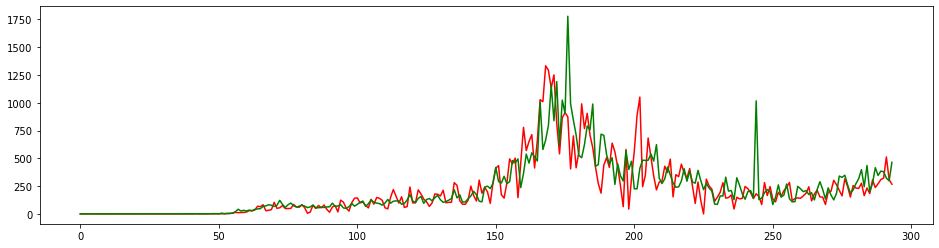

mse 42.63379902742347


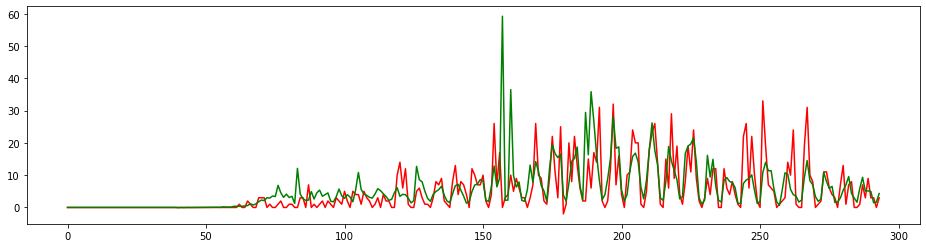

In [139]:
plotPrediction(rnn, 'Orange', 'CA')

#x nan: 0
mse 10983.91156462585


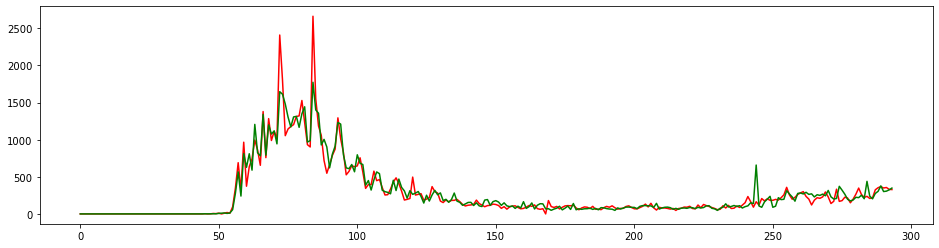

mse 267.06752232142856


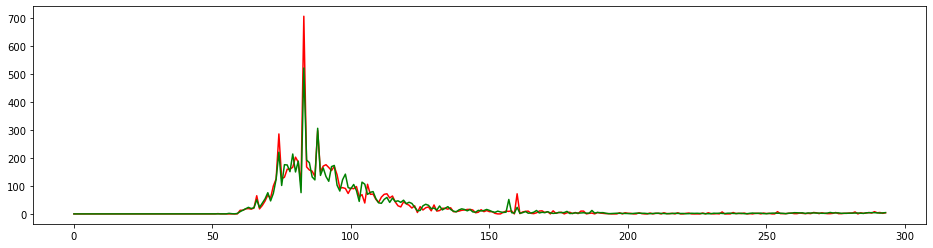

In [138]:
plotPrediction(rnn, 'Kings', 'NY')